In [57]:
# Install dependencies
!pip install kagglehub seaborn scikit-learn matplotlib

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import json
import kagglehub


In [58]:
#Downloading Dataset Using KaggleHub

path = kagglehub.dataset_download("kaushil268/disease-prediction-using-machine-learning")
print("Path to dataset files:", path)

# Function to locate the Kaggle dataset within the downloaded path
def locate_dataset(root_dir=path):  # Using 'path' as the default root_dir
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for file in filenames:
            if file == "Training.csv":
                return os.path.join(dirpath, file)
    raise FileNotFoundError("Dataset 'Training.csv' not found in the downloaded directory.")

# Locate the dataset within the downloaded path
try:
    dataset_path = locate_dataset()
    print(f"Dataset found at: {dataset_path}")
except FileNotFoundError as e:
    print(e)
    raise


Path to dataset files: /root/.cache/kagglehub/datasets/kaushil268/disease-prediction-using-machine-learning/versions/1
Dataset found at: /root/.cache/kagglehub/datasets/kaushil268/disease-prediction-using-machine-learning/versions/1/Training.csv


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB
None

Sample Data:
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0    

<ipython-input-59-b9ee77d89335>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="viridis")


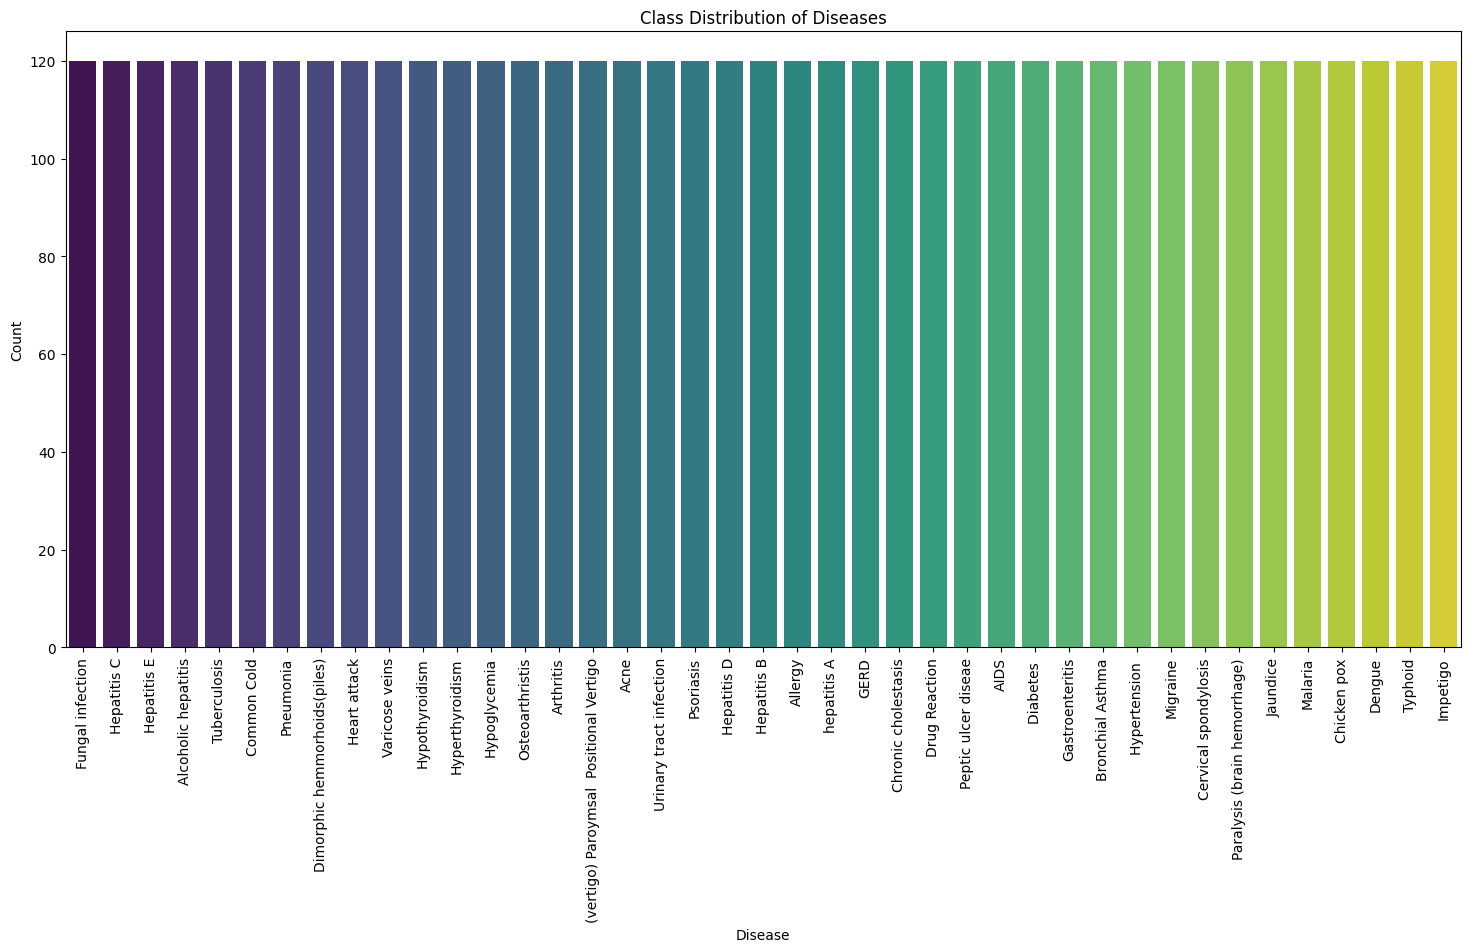

In [59]:
#Loading and Exploring


data = pd.read_csv(dataset_path).dropna(axis=1)

# Data exploration
print("Dataset Info:")
print(data.info())
print("\nSample Data:")
print(data.head())

# Check for class imbalance
disease_counts = data["prognosis"].value_counts()
plt.figure(figsize=(18, 8))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Class Distribution of Diseases")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.show()


In [60]:
# Data Preprocessing

# Encoding target labels
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])

# Splitting features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
print(f"Train Data: {X_train.shape}, Test Data: {X_test.shape}")


Train Data: (3936, 132), Test Data: (984, 132)


In [61]:
#Model Training and Cross-validation

# Models to evaluate
models = {
    "SVC": SVC(),
    "GaussianNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=18),
}

# Cross-validation and model selection
def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring=cv_scoring)
    print(f"{model_name} - CV Accuracy: {np.mean(scores) * 100:.2f}%")


SVC - CV Accuracy: 100.00%
GaussianNB - CV Accuracy: 100.00%
RandomForest - CV Accuracy: 100.00%


In [ ]:
#Final Model Training

# Training final models
final_rf_model = RandomForestClassifier(random_state=18)
final_rf_model.fit(X_train, y_train)

final_nb_model = GaussianNB()
final_nb_model.fit(X_train, y_train)

final_svm_model = SVC(probability=True)
final_svm_model.fit(X_train, y_train)


SVC(probability=True)

Random Forest Accuracy: 100.00%


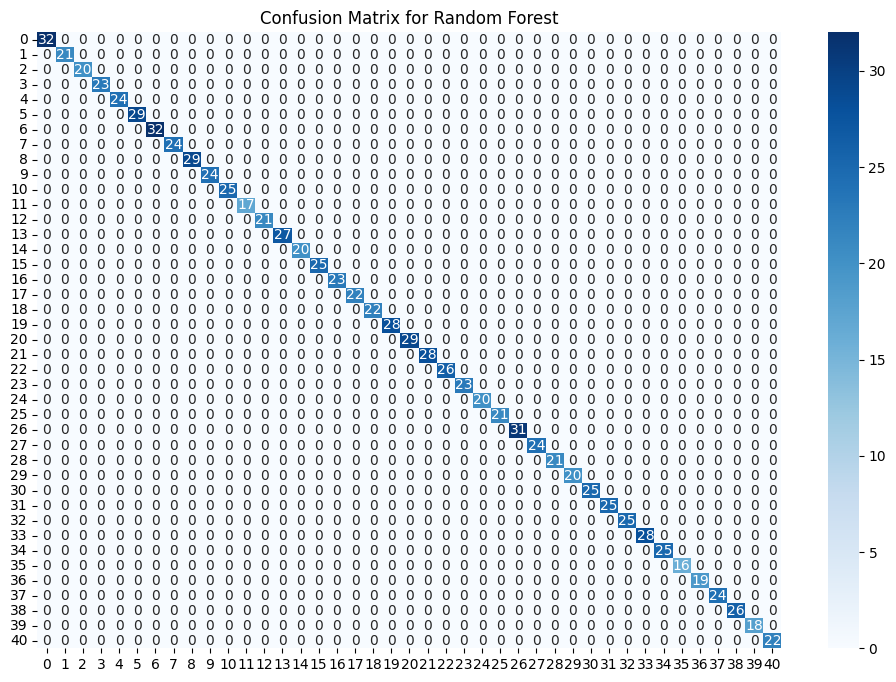

Naive Bayes Accuracy: 100.00%


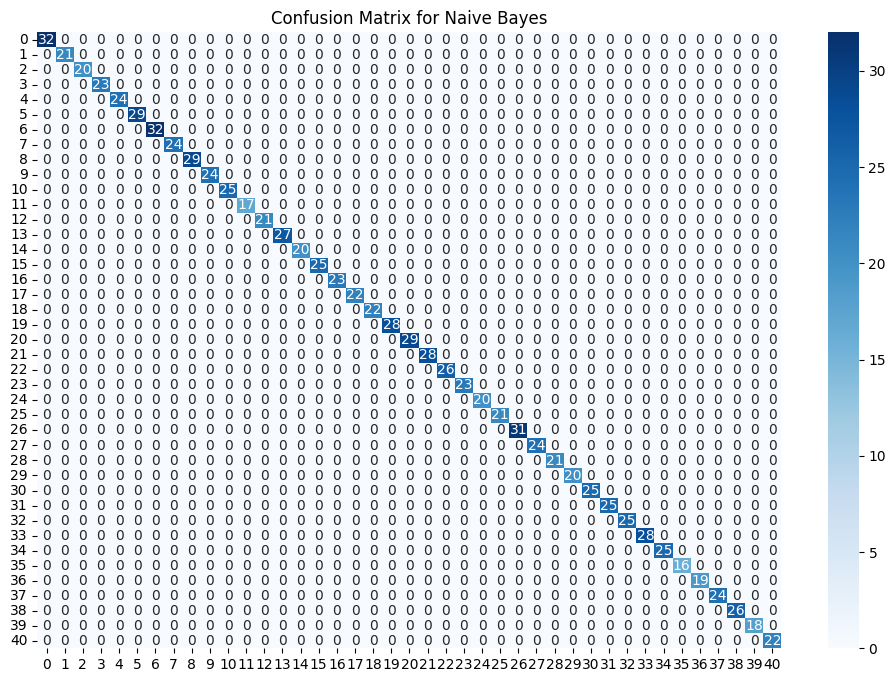

SVM Accuracy: 100.00%


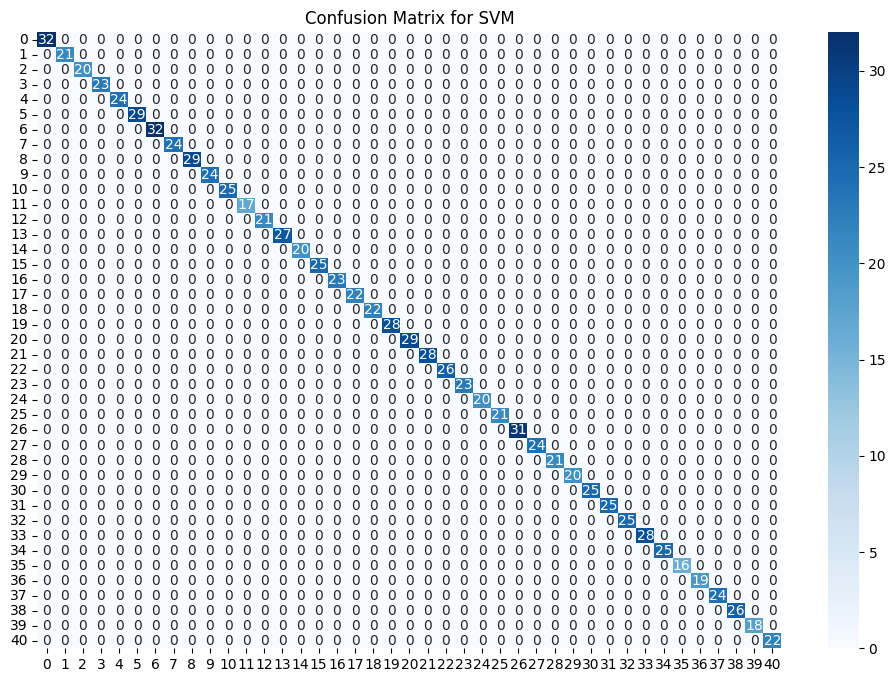

In [ ]:
# Model Evaluation

# Evaluate models on test set
def evaluate_model(model, model_name):
    preds = model.predict(X_test)
    print(f"{model_name} Accuracy: {accuracy_score(y_test, preds) * 100:.2f}%")
    cf_matrix = confusion_matrix(y_test, preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Evaluate Random Forest Model
evaluate_model(final_rf_model, "Random Forest")

# Evaluate Naive Bayes Model
evaluate_model(final_nb_model, "Naive Bayes")

# Evaluate SVM Model
evaluate_model(final_svm_model, "SVM")


In [ ]:
# Predict Disease Function

# Predict function to handle user input
def predictDisease(user_input):
    # Map user input symptoms to a feature vector
    input_symptoms = user_input.split(",")  # Assume input is a comma-separated list
    feature_vector = np.zeros(len(X.columns))  # Create a zeroed feature vector
    for symptom in input_symptoms:
        symptom = symptom.strip().lower()  # Normalize input
        if symptom in X.columns:
            feature_vector[X.columns.get_loc(symptom)] = 1  # Mark the symptom as present

    # Make predictions using each model
    svm_pred = final_svm_model.predict([feature_vector])[0]
    nb_pred = final_nb_model.predict([feature_vector])[0]
    rf_pred = final_rf_model.predict([feature_vector])[0]

    # Return predictions as a dictionary
    predictions = {
        'svm': encoder.inverse_transform([svm_pred])[0],
        'naive_bayes': encoder.inverse_transform([nb_pred])[0],
        'random_forest': encoder.inverse_transform([rf_pred])[0]
    }

    return predictions


In [ ]:

# User input and prediction function
def get_user_input_and_predict():
    print("Welcome to the Disease Prediction System!")
    print("Please enter your symptoms, separated by commas (e.g., Itching,Skin Rash).")
    print("Note: Symptoms must be as close to standard terms as possible.")

    # Take input from the user
    user_input = input("Enter symptoms: ").strip()

    # Call the prediction function
    predictions = predictDisease(user_input)

    # Prepare a result dictionary
    if not predictions:
        print("Error: No valid symptoms provided.")
        return
    else:
        print("\nPredictions based on your symptoms:")
        result = {"Symptoms": user_input}
        for model, prediction in predictions.items():
            print(f"{model.replace('_', ' ').capitalize()}: {prediction}")
            result[model.replace("_", " ").capitalize()] = prediction

    # Append result to JSON file
    try:
        with open("predictions.json", "r") as file:
            existing_results = json.load(file)
    except FileNotFoundError:
        existing_results = []

    # Append new result and save back
    existing_results.append(result)
    with open("predictions.json", "w") as file:
        json.dump(existing_results, file, indent=4)

    print("\nPrediction saved to 'predictions.json'")

# Example usage of the system
get_user_input_and_predict()


Welcome to the Disease Prediction System!
Please enter your symptoms, separated by commas (e.g., Itching,Skin Rash).
Note: Symptoms must be as close to standard terms as possible.
Enter symptoms: Itching,Skin Rash,Nodal Skin Eruptions

Predictions based on your symptoms:
Svm: Fungal infection
Naive bayes: Fungal infection
Random forest: Fungal infection

Prediction saved to 'predictions.json'


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
